In [36]:
from collections import Counter
import sqlite3, math, csv, re
import pandas as pd
from emoji import UNICODE_EMOJI

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
%matplotlib inline
#%matplotlib qt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_absolute_error
import xgboost as xgb

In [3]:
db = "/home/jeslev/Downloads/sample_3days.sqlite"

conn = sqlite3.connect(db)
c = conn.cursor()

In [12]:
# original DB sample, without users removed
db = "/home/jeslev/Downloads/sample_3days.sqlite.bkp"

conn = sqlite3.connect(db)
c = conn.cursor()

In [3]:
#test query
query = "SELECT count(*)  FROM May2015 "


lines = c.execute(query)
for line in lines:
    print(line)

(4507592,)


# Cleaning dataset (removing users)

We select all users with less than 7000 comments in the complete month because there is almost impossible to have more than that amount for a human being.

In [35]:
banned_users = "'', '[deleted]', 'AutoModerator', 'autowikibot', 'TweetsInCommentsBot', 'TweetPoster', 'TrollaBot', 'MTGCardFetcher', 'havoc_bot', 'TotesMessenger', 'TheNitromeFan', 'PoliticBot', 'autotldr', 'Late_Night_Grumbler', 'SharksPwn', 'WritingPromptsRobot', 'atomicimploder', 'Marvelvsdc00'"

In [36]:
# DELETE users identified as bots or deleted
query = "DELETE  FROM May2015 WHERE author IN  ("+banned_users+") "
#query

l = c.execute(query)
conn.commit()

# Total comments: 4507592

In [4]:
# most popular subreddits by  authors
lines = c.execute("SELECT author,subreddit_id, subreddit, count(*) as FreqCmt  FROM May2015 GROUP BY author ORDER BY FreqCmt DESC LIMIT 20")
for line in lines:
    print(line)

('Removedpixel', 't5_2u9jq', 'counting', 2113)
('reginaldtato', 't5_2qm4e', 'askscience', 1920)
('Mooraell', 't5_2u9jq', 'counting', 1270)
('sontato', 't5_2qj7m', 'mobileweb', 1171)
('Car5V', 't5_2r8c5', 'jailbreak', 979)
('NoBreadsticks', 't5_2u9jq', 'counting', 960)
('LittleHelperRobot', 't5_2r8tu', 'woahdude', 877)
('Look_Its_Mila', 't5_34k5q', 'CampHalfBloodRP', 831)
('aussie1530', 't5_33z5m', 'TheDescendantsOfRome', 773)
('Thaddeus-J-Spiderman', 't5_31uz5', 'XMenRP', 735)
('reddtipbot', 't5_37mhq', 'GetFairShare', 724)
('SkydivingHaylz', 't5_2ub11', 'Pokemongiveaway', 623)
('rollme', 't5_30yfr', 'worldpowers', 603)
('CallMeEzra', 't5_323oy', 'CasualConversation', 599)
('the_stormborn', 't5_31uz5', 'XMenRP', 599)
('imgurtranscriber', 't5_2s7tt', 'AdviceAnimals', 542)
('Koemi_Rapp', 't5_33lo3', 'YamakuHighSchool', 532)
('GustavoFrings', 't5_2qh1i', 'AskReddit', 523)
('GoomyTooOP', 't5_2ub11', 'Pokemongiveaway', 521)
('tipnyan', 't5_37mhq', 'GetFairShare', 500)


In [5]:
# avg ups per subreddit
lines = c.execute("SELECT subreddit_id, subreddit, MIN(ups), MAX(ups), AVG(ups)  FROM May2015 GROUP BY subreddit_id LIMIT 20")
for line in lines:
    print(line)

('t5_1a8ah', 'obama', -18, 13, 2.6)
('t5_1efbr', 'ads', -6, 12, 1.8804347826086956)
('t5_1rqwi', 'netsec', -13, 56, 4.053691275167785)
('t5_21nj', 'request', 1, 1, 1.0)
('t5_22i0', 'de', -34, 71, 3.8793456032719837)
('t5_22i2', 'es', 0, 1, 0.75)
('t5_247e', 'no', 1, 1, 1.0)
('t5_247h', 'ca', 1, 1, 1.0)
('t5_247i', 'ru', 0, 0, 0.0)
('t5_2cneq', 'politics', -96, 3663, 6.805849655902594)
('t5_2fwo', 'programming', -47, 750, 5.55655686761964)
('t5_2h84o', 'bugs', -1, 3, 1.3409090909090908)
('t5_2qgzg', 'business', -29, 68, 3.657967032967033)
('t5_2qgzt', 'gadgets', -35, 1406, 5.303804347826087)
('t5_2qgzy', 'sports', -79, 3431, 10.217625)
('t5_2qh03', 'gaming', -225, 4480, 9.717256926768963)
('t5_2qh0f', 'entertainment', -23, 88, 4.349137931034483)
('t5_2qh0k', 'cogsci', 1, 7, 3.5)
('t5_2qh0n', 'math', -19, 349, 6.3316023738872405)
('t5_2qh0p', 'robotics', -2, 10, 1.912621359223301)


## Preparing train/test set

In [38]:
lines = c.execute("SELECT count(*) FROM May2015")
tot = 0
for line in lines:
    tot = line[0]
tot

4507592

In [41]:
lines = c.execute("SELECT id FROM May2015 ORDER BY created_utc ASC")
ids_train, ids_test= [], []
limit = 2*tot/3

ftr = open('trainID.txt','w')
fts = open('testID.txt','w')
for idx,item in enumerate(lines):
    if idx<limit:
        ftr.write("%s\n" % item)
    else:
        fts.write("%s\n" % item)
ftr.close()
fts.close()

## Select subsample with 1.5M to analyze features

In [36]:
lines = c.execute("SELECT created_utc, ups, subreddit_id, id, gilded, author, body, parent_id FROM May2015 ORDER BY created_utc ASC LIMIT 1500000")
columns = ["created_utc", "ups", "subreddit_id", "id", "gilded", "author", "body", "parent_id"]
data = []
for line in lines:
    data.append(list(line))

In [37]:
df = pd.DataFrame(data, columns=columns)

In [45]:
df.tail()

,created_utc,ups,subreddit_id,id,gilded,author,body,parent_id
1499995,1430515265,1,t5_2rfxx,cqvfm51,0,gpm479,"Oh haha, didn't realize that! Good to know. Ly...",t1_cqvf4wr
1499996,1430515265,2,t5_2t403,cqvfm52,0,Carbon_Dirt,[](/fluttertree)Pine!,t1_cqvfk6q
1499997,1430515265,16,t5_2qhj4,cqvfm53,0,cmdertx,"Maybe you would, but I remember a certain DWI/...",t1_cqvf0a6
1499998,1430515265,2,t5_2sh9s,cqvfm54,0,x1498,De hecho los saqueadores son solo pequeños gru...,t1_cqvadla
1499999,1430515265,-1,t5_2cneq,cqvfm55,0,FortMark,Police should just stay away from crime ridden...,t3_34ix05


## Extract direct features from table

In [4]:
def findURL(string): 
    # findall() has been used  
    # with valid conditions for urls in string 
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string)
    return urls 
      
def removeURL(string): 
    # findall() has been used  
    # with valid conditions for urls in string 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '',string)
    return text 

def has_emoji(s):
    count = 0
    for emoji in UNICODE_EMOJI:
        count += s.count(emoji)
    return count

def remove_emoji(text):
    for emoji in UNICODE_EMOJI:
        text = text.replace(emoji,'')
    return text

def getStyleFeatures(row):
    '''
    Features: # urls, # emojis, bool for signs, # words in body
    '''
    text = row['body']
    text = text.lower()
    
    n_urls = 0
    n_emojis = 0
    
    urls = findURL(text)
    n_urls = len(urls)
    #remove URLs
    text = removeURL(text)
    
    # find emojis
    n_emojis = has_emoji(text)
    text = remove_emoji(text)
    
    signs = re.findall('[^a-zA-Z\d\s:]+',text)
    n_signs = 0
    if len(signs)>0:
        n_signs = 1
        #print(signs,text)
    text = re.sub('[^a-zA-Z\d\s:]+',' ',text)
    
    word_tokens = word_tokenize(text) 
    filtered_text = [w for w in word_tokens if not w in stop_words] 
    richesse = len(set(filtered_text))
    vector = [richesse, n_urls, n_emojis, n_signs, row['ups'], row['id']]
    
    return vector#, " ".join(filtered_text)

In [7]:
# get features from subsample
feats = []
cnt = 0
for index, row in df.iterrows():
    ft = getStyleFeatures(row)
    #if cnt<10:
    #    print(ft)
    if ft[0]==0:
        continue
    feats.append(ft)
    cnt+=1
    if cnt%100000==0:
        print(cnt)
    #print(txt)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000


In [40]:
# oops!, i forgot to obtain the day from time column
selected_ids = set(df2['id'])
days = []
cnt = 0
for index, row in df.iterrows():
    if row['id'] in selected_ids:
        days.append(datetime.datetime.utcfromtimestamp(seconds).day)

In [8]:
# save to a file (it takes >2h to recompute!)
cols = ['Vocab','Urls','Emojis','Signs','UPS','id']
df2 = pd.DataFrame(feats, columns=cols)
df2.to_csv('feats.csv',index=False, sep='\t')

In [43]:
# adding the  days columns i forgot
df2['days'] = days
df2.to_csv('feats.csv',index=False, sep='\t')

In [67]:
# load features
df2 = pd.read_csv('feats.csv',sep='\t')
df2.head(20)

,Vocab,Urls,Emojis,Signs,UPS,id,days
0,6,0,0,1,4,cqug90h,1
1,20,0,0,1,0,cqug90i,1
2,7,0,0,1,3,cqug90j,1
3,5,0,0,1,3,cqug90k,1
4,11,0,0,1,1,cqug90l,1
5,16,0,0,1,6,cqug90m,1
6,4,0,0,1,2,cqug90n,1
7,6,0,0,0,6,cqug90o,1
8,17,0,0,1,5,cqug90p,1
9,1,0,0,0,4,cqug90q,1


# Analyzing features

In [27]:
len(df2),len(df3)

(1477359, 1458822)

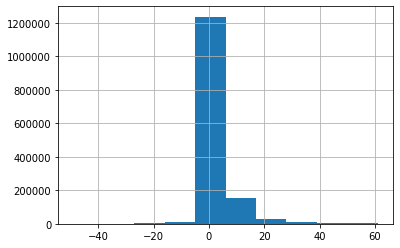

In [22]:
#plot hist UPS
avg = df2['UPS'].mean()
df3 = df2[np.abs(df2['UPS']-avg) <= df2['UPS'].std()]
df3['UPS'].hist(bins=10)

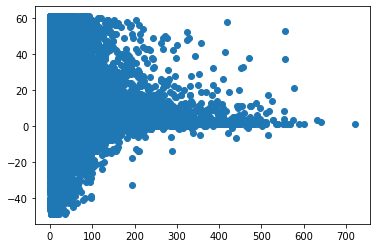

In [23]:
# plot
plt.scatter( df3['Vocab'],df3['UPS'])
plt.show()

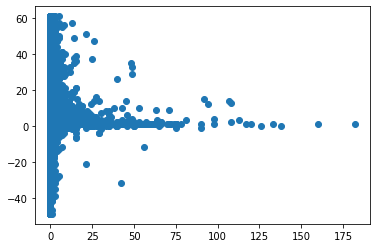

In [24]:
# plot
plt.scatter( df3['Urls'],df3['UPS'])
plt.show()

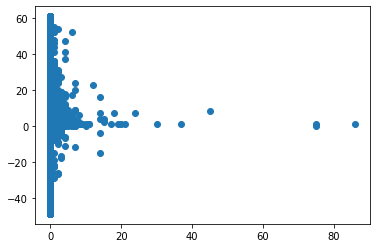

In [25]:
# plot
plt.scatter(df3['Emojis'],df3['UPS'])
plt.show()

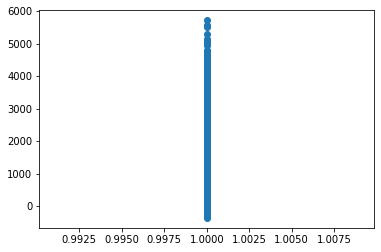

In [26]:
# plot
plt.scatter(df2['days'],df2['UPS'])
plt.show()

# Models
## XGBoost

In [70]:
ref = abs(df2['UPS'].min())

In [86]:
#X = df2[['Vocab','days']]
X = df2[['Vocab','Urls','Emojis','Signs','days']]
y = df2['UPS'].copy()
y += ref + 1e-6
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)


xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42, eval_metric='mae', n_estimators=100)


xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

y_pred = np.exp(y_pred)-ref-1e-6
y_test = np.exp(y_test)-ref-1e-6
#round results
#y_pred = y_pred.round()
#pd.to_numeric(y_pred, downcast='signed')

mae=mean_absolute_error(y_test, y_pred)
mae

/home/jeslev/anaconda3/envs/reddit/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:11:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


7.425111682909605

In [81]:
X = df2[['days']]
y = df2['UPS'].copy()
y += ref + 1e-6
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)


xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42, max_depth=4,eval_metric='mae', n_estimators=10)


xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

y_pred = np.exp(y_pred)-ref-1e-6
y_test = np.exp(y_test)-ref-1e-6
#round results
#y_pred = y_pred.round()
#pd.to_numeric(y_pred, downcast='signed')

mae=mean_absolute_error(y_test, y_pred)
mae

/home/jeslev/anaconda3/envs/reddit/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:03:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


304.48606734254895

In [ ]:
pd.to_numeric(y_pred, downcast='signed'), y_pred

In [54]:
confusion_matrix(y_test, y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

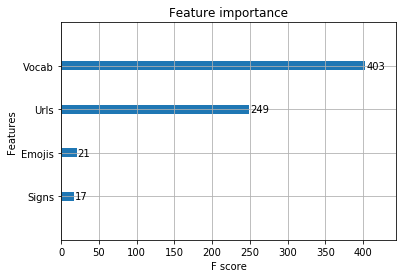

In [55]:
xgb.plot_importance(xgb_model)